In [79]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [100]:
N_CLUSTERS = 27

In [101]:
raw_data = np.loadtxt('EEG_feature.txt')
# print(raw_data.shape)
emotion_label = np.loadtxt('EEG_emotion_category.txt')
# print(emotion_label)
subject_video_label = np.loadtxt('subject_video.txt')
#print(subject_video_label[:,0])
valence_arousal_label = np.loadtxt('valence_arousal_label.txt')

In [102]:
pca = PCA(n_components=2)
pcaout = pca.fit_transform(raw_data)
# print(out.shape)
# print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

0.6134818748411892


In [103]:
class cluster_eval(object):
    def _dist(self, x, y):
        return np.sum((x - y) ** 2) ** 0.5
    def __init__(self, raw_data):
        self.raw_data = raw_data
        self.dis = [[self._dist(raw_data[i], raw_data[j]) for j in range(i)] for i in range(len(raw_data))]
    def eval(self, label, centers, clusters):
        self.clu_label = [[] for i in range(clusters)]
        for i in range(len(label)):
            self.clu_label[label[i]].append(i)
        centers = [np.mean(self.raw_data[self.clu_label[i]], axis=0) for i in range(clusters)]
        # avg, diam
        self.clu_avg = [0 for i in range(clusters)]
        self.diam = [0 for i in range(clusters)]
        for i in range(clusters):
            clu_num = len(self.clu_label[i])
            for j in range(clu_num):
                for k in range(j):
                    jk_dis = self.dis[self.clu_label[i][j]][self.clu_label[i][k]]
                    self.clu_avg[i] += jk_dis
                    self.diam[i] = max(self.diam[i], jk_dis)
            self.clu_avg[i] *= 2 / (clu_num * (clu_num - 1))
        # dcen
        self.cen = [[self._dist(centers[i], centers[j]) for j in range(i)] for i in range(clusters)]
        # dmin
        self.dmin = [[j for j in i] for i in self.cen]
        for i in range(clusters):
            for j in range(i):
                for k in self.clu_label[i]:
                    for l in self.clu_label[j]:
                        self.dmin[i][j] = min(self.dmin[i][j], self.dis[max(k, l)][min(k, l)])
        # DBI
        self.DBI = sum(max(self.cen[max(i, j)][min(i, j)] for j in list(range(i)) + list(range(i + 1, clusters))) for i in range(clusters)) / clusters
        # print(self.DBI)
        # Dunn
        self.Dunn = min(min(i) for i in self.dmin[1:]) / max(self.diam)
        # print(self.Dunn)

In [76]:
for n_clusters in [2, 3, 4, 5, 6, 8, 10, 20, 27]:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeansout = kmeans.fit(raw_data)
    e = cluster_eval(raw_data)
    e.eval(kmeansout.labels_, kmeansout.cluster_centers_, n_clusters)
    print(n_clusters, e.DBI, e.Dunn)

2 10.755191104175807 0.11357909846273724
3 11.637803715191382 0.11925414282597609
4 14.196207104072498 0.10171404234036222
5 16.583435796386283 0.1115208848692516
6 16.9820886475689 0.11322976735266632
8 16.987027117433342 0.11301040075120312
10 18.44189905192855 0.11301040075120312
20 19.20030677052436 0.13388879831333833
27 19.02293276538956 0.16310169753932946


In [77]:
for n_clusters in [2, 3, 4, 5, 6, 8, 10, 20, 27]:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, init='random')
    kmeansout = kmeans.fit(raw_data)
    e = cluster_eval(raw_data)
    e.eval(kmeansout.labels_, kmeansout.cluster_centers_, n_clusters)
    print(n_clusters, e.DBI, e.Dunn)

2 10.755191104175807 0.11357909846273724
3 11.637803715191382 0.11925414282597609
4 14.196207104072498 0.10171404234036222
5 16.58658385777985 0.10681920778101599
6 17.037998082205416 0.11322976735266632
8 17.230296655826017 0.11257056067673682
10 18.688770527827124 0.1273459983926281
20 19.358320622312085 0.1516841482792527
27 19.12305798959135 0.1400293157661443


In [83]:
#for covariance_type in ['full', 'tied', 'diag', 'spherical']:
#    n_clusters = 6
for n_clusters in [2, 3, 4, 5, 6, 8, 10, 20, 27]:
    gm = GaussianMixture(n_components=n_clusters, covariance_type='full')
    gmout = gm.fit_predict(raw_data)
    e = cluster_eval(raw_data)
    e.eval(gmout, None, n_clusters)
    print(n_clusters, e.DBI, e.Dunn)

2 10.074646372257986 0.07345554807667375
3 11.637803715191382 0.11925414282597609
4 14.084011144953836 0.10888567231389619
5 16.576772324840583 0.11322976735266632
6 16.92881798440417 0.11322976735266632
8 17.489696257023883 0.12493266414007002
10 17.387773672275916 0.12686601817873303
20 18.87900805324153 0.12284503873292893
27 18.904451218608592 0.13382830524960287


In [104]:
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0)
kmeansout = kmeans.fit(raw_data)
colors = cm.rainbow(np.linspace(0, 1, N_CLUSTERS))
clu_colors = [colors[i] for i in kmeansout.labels_]

In [89]:
def jaccard(clu_label, label):
    n = len(clu_label)
    a = 0
    bc = 0
    for i in range(n):
        for j in range(i):
            if clu_label[i] == clu_label[j] and label[i] == label[j]:
                a += 1
            if clu_label[i] != clu_label[j] and label[i] == label[j]:
                bc += 1
            if clu_label[i] == clu_label[j] and label[i] == label[j]:
                bc += 1
    return a / (a + bc)                

In [99]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeansout = kmeans.fit(raw_data).labels_
subject_label = subject_video_label[:, 0]
video_label = subject_video_label[:, 1]
valence_arousal_label0 = valence_arousal_label[:, 0]
valence_arousal_label1 = valence_arousal_label[:, 1]
print(jaccard(kmeansout, valence_arousal_label0))
print(jaccard(kmeansout, valence_arousal_label1))

0.35411889461901697
0.35525080869287895


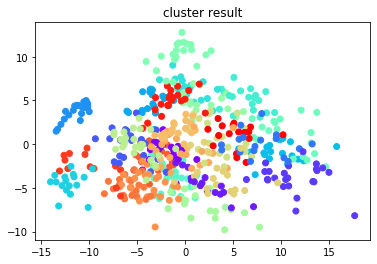

In [105]:
plt.title('cluster result')
plt.scatter(pcaout[..., 0], pcaout[..., 1], c=clu_colors)

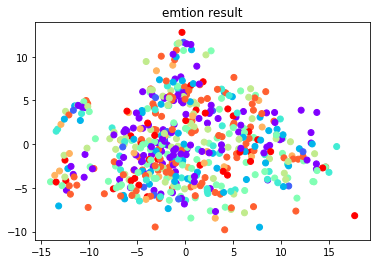

In [20]:
k = {0:0,1:1,2:2,3:3,4:4,5:5,6:6,11:7,12:8}
colors = cm.rainbow(np.linspace(0, 1, 9))
emt_colors = [colors[k[i]] for i in emotion_label]
plt.title('emtion result')
plt.scatter(pcaout[..., 0], pcaout[..., 1], c=emt_colors)

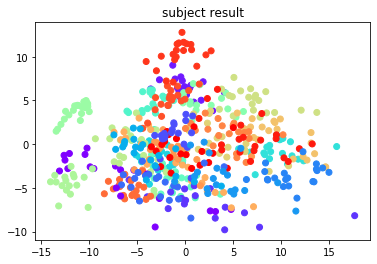

In [108]:
colors = cm.rainbow(np.linspace(0, 1, 30))
v_colors = [colors[int(i[0]) - 1] for i in subject_video_label]
plt.title('subject result')
plt.scatter(pcaout[..., 0], pcaout[..., 1], c=v_colors)